In [1]:
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import json
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("All_Diets_cleaned.csv")

In [3]:
df.head(10)

,Recipe_name,Protein(g),Carbs(g),Fat(g),Extraction_day,Extraction_time,Diet_type_dash,Diet_type_keto,Diet_type_mediterranean,Diet_type_paleo,...,Cuisine_type_italian,Cuisine_type_japanese,Cuisine_type_kosher,Cuisine_type_mediterranean,Cuisine_type_mexican,Cuisine_type_middle eastern,Cuisine_type_nordic,Cuisine_type_south american,Cuisine_type_south east asian,Cuisine_type_world
0,bone broth from nom nom,5.22,1.29,3.20,2022-10-16,17:20:09,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1,effect asian glazed pork side sweet crispy app...,181.55,28.62,146.14,2022-10-16,17:20:09,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False
2,pumpkin pie,30.91,302.59,96.76,2022-10-16,17:20:09,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
3,strawberry guacamole,9.62,75.78,59.89,2022-10-16,17:20:09,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
4,asian cauliflower fried rice from nom nom,39.84,54.08,71.55,2022-10-16,17:20:09,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
5,shrimp stuffed mushroom,68.62,34.15,42.44,2022-10-16,17:20:09,False,False,False,True,...,False,False,False,True,False,False,False,False,False,False
6,pumpkin pie,30.03,275.88,97.68,2022-10-16,17:20:09,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
7,autoimmune pesto,4.25,14.15,72.90,2022-10-16,17:20:09,False,False,False,True,...,True,False,False,False,False,False,False,False,False,False
8,baked banana chip encrusted french toast,152.88,1874.52,385.80,2022-10-16,17:20:09,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
9,vietnamese pho pressure cooker noodle soup,602.91,274.87,400.01,2022-10-16,17:20:09,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False


In [4]:
recipes = df["Recipe_name"]
embedding_size = 100
tokenized_recipes = [word_tokenize(sentence) for sentence in recipes]
model = Word2Vec(sentences=tokenized_recipes, vector_size=embedding_size, window=5, min_count=1, workers=4,epochs=15)


In [5]:
with open("tagged_diets.json","r") as file:
    tags_dictionary = json.load(file)

tags_dictionary[:10]

[{'nouns': ['bone', 'broth', 'nom'], 'adjectives': ['nom']},
 {'nouns': ['effect', 'pork', 'side', 'crispy', 'appetizer'],
  'adjectives': ['asian', 'sweet']},
 {'nouns': ['pumpkin', 'pie'], 'adjectives': []},
 {'nouns': ['strawberry', 'guacamole'], 'adjectives': []},
 {'nouns': ['cauliflower', 'rice', 'nom'], 'adjectives': ['asian', 'nom']},
 {'nouns': ['shrimp', 'mushroom'], 'adjectives': []},
 {'nouns': ['pumpkin', 'pie'], 'adjectives': []},
 {'nouns': ['autoimmune', 'pesto'], 'adjectives': []},
 {'nouns': ['banana', 'chip', 'toast'], 'adjectives': ['french']},
 {'nouns': ['pho', 'pressure', 'cooker', 'soup'],
  'adjectives': ['vietnamese', 'noodle']}]

In [6]:
model_vocab = set(model.wv.index_to_key)

nouns_features_list = []
adjectives_features_list = []
all_nouns = []
for index,tags in enumerate(tags_dictionary):
    nouns = tags["nouns"]
    all_nouns.append(nouns)
    adjectives = tags["adjectives"]
    if adjectives == []:
        adjectives_features = [0 for _ in range(embedding_size)]
    else:
        allowed_adjectives = [adjective for adjective in adjectives if adjective in model_vocab]
        if allowed_adjectives == []:
            adjectives_features = [0 for _ in range(embedding_size)]
        else:
            adjectives_features = np.mean([model.wv[adj] for adj in allowed_adjectives],axis=0)
    if nouns == []:
            allowed_words = [word for word in recipes[index].split() if word in model_vocab]
            nouns_features = np.mean([model.wv[word] for word in allowed_words],axis=0)
    else:
        allowed_nouns = [noun for noun in recipes[index].split() if noun in model_vocab]
        if allowed_nouns==[]:
            allowed_words = [word for word in recipes[index].split() if word in model_vocab]
            nouns_features = np.mean([model.wv[word] for word in allowed_words],axis=0)
        else:
            nouns_features = np.mean([model.wv[noun] for noun in allowed_nouns],axis=0)
    nouns_features_list.append(nouns_features)
    adjectives_features_list.append(adjectives_features)
    

In [7]:
nouns_features_list = np.array(nouns_features_list)
adjectives_features_list = np.array(adjectives_features_list)

In [8]:
embeddings_features = nouns_features_list + adjectives_features_list
embeddings_features.shape

(7804, 100)

In [9]:
macronutrients = df.iloc[:,1:4]
macronutrients = np.array(macronutrients)
macronutrients

array([[5.2200e+00, 1.2900e+00, 3.2000e+00],
       [1.8155e+02, 2.8620e+01, 1.4614e+02],
       [3.0910e+01, 3.0259e+02, 9.6760e+01],
       ...,
       [1.0000e-02, 3.9000e-01, 0.0000e+00],
       [1.5538e+02, 2.3988e+02, 2.6084e+02],
       [2.0000e-02, 8.3000e-01, 0.0000e+00]])

In [10]:
diet_types = df.iloc[:,6:]
diet_types = np.array(diet_types,dtype=int)
diet_types

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [11]:
all_features = np.hstack((embeddings_features,diet_types,macronutrients))
all_features.shape

(7804, 127)

In [26]:
tsne = TSNE(n_components=3, random_state=0,verbose=1,n_iter=1500)
X_embedded = tsne.fit_transform(all_features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7804 samples in 0.001s...
[t-SNE] Computed neighbors for 7804 samples in 0.686s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7804
[t-SNE] Computed conditional probabilities for sample 2000 / 7804
[t-SNE] Computed conditional probabilities for sample 3000 / 7804
[t-SNE] Computed conditional probabilities for sample 4000 / 7804
[t-SNE] Computed conditional probabilities for sample 5000 / 7804
[t-SNE] Computed conditional probabilities for sample 6000 / 7804
[t-SNE] Computed conditional probabilities for sample 7000 / 7804
[t-SNE] Computed conditional probabilities for sample 7804 / 7804
[t-SNE] Mean sigma: 8.514802
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.256401


KeyboardInterrupt: 

In [13]:
types = df.iloc[:,6:11]
types.to_numpy(dtype=int)
column_names = df.columns[6:11]
colors = ['red', 'blue', 'green', 'orange','magenta']
color_indices = np.argmax(types, axis=1)
point_colors = [colors[idx] for idx in color_indices]
markers = ['p','s','o','x','D']
angles =[0,45,90,135]
selected_indices = []
for i in range(len(colors)):
    indices = np.where(color_indices == i)[0]
    selected_indices.append(np.random.choice(indices, size=25, replace=False))
selected_indices = np.array(selected_indices)

C:\Users\uma_i\AppData\Local\Temp\ipykernel_18976\1920935302.py:9: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(X_embedded[class_indices, 0], X_embedded[class_indices, 1], X_embedded[class_indices, 2],


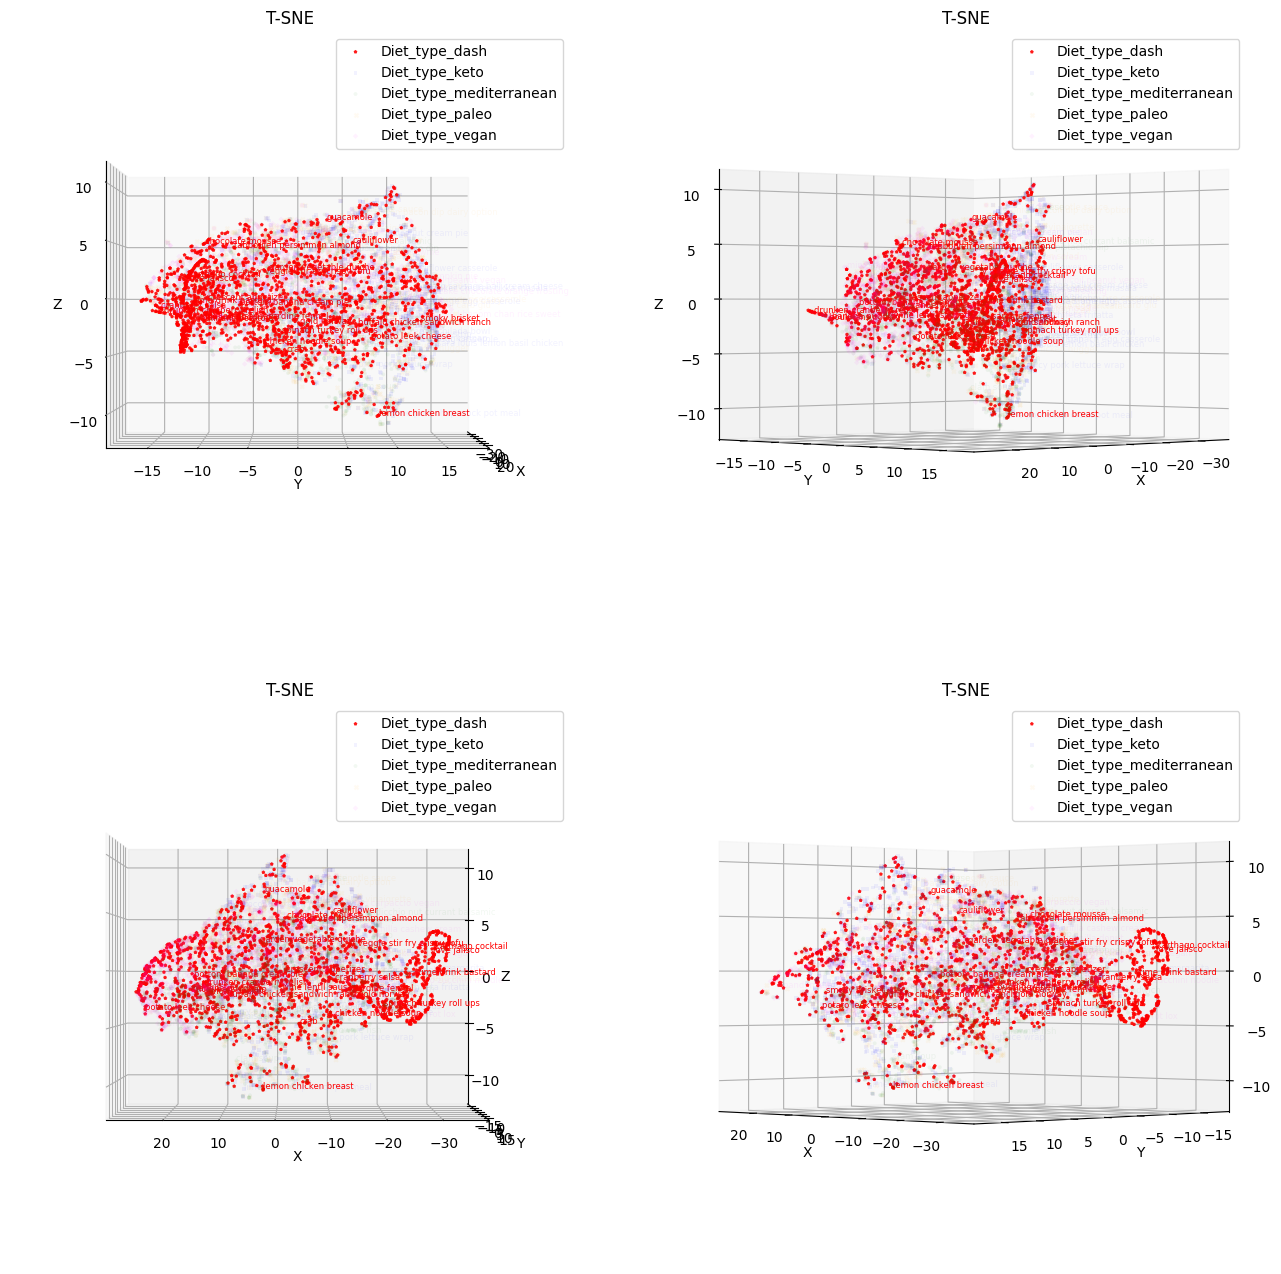

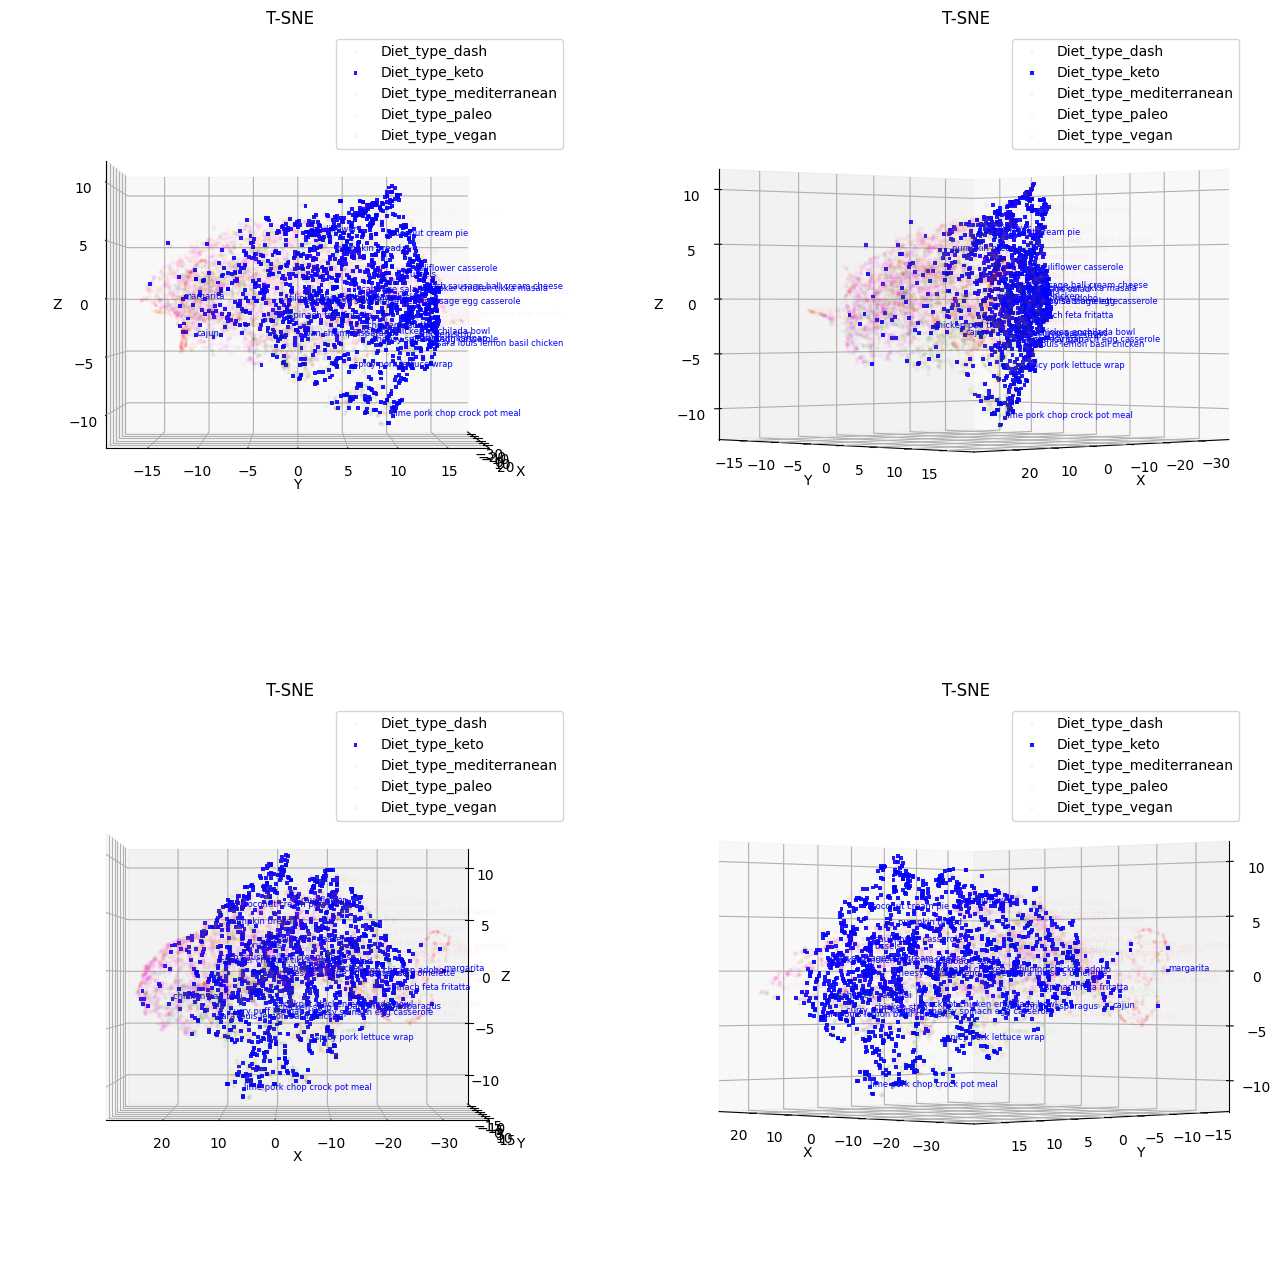

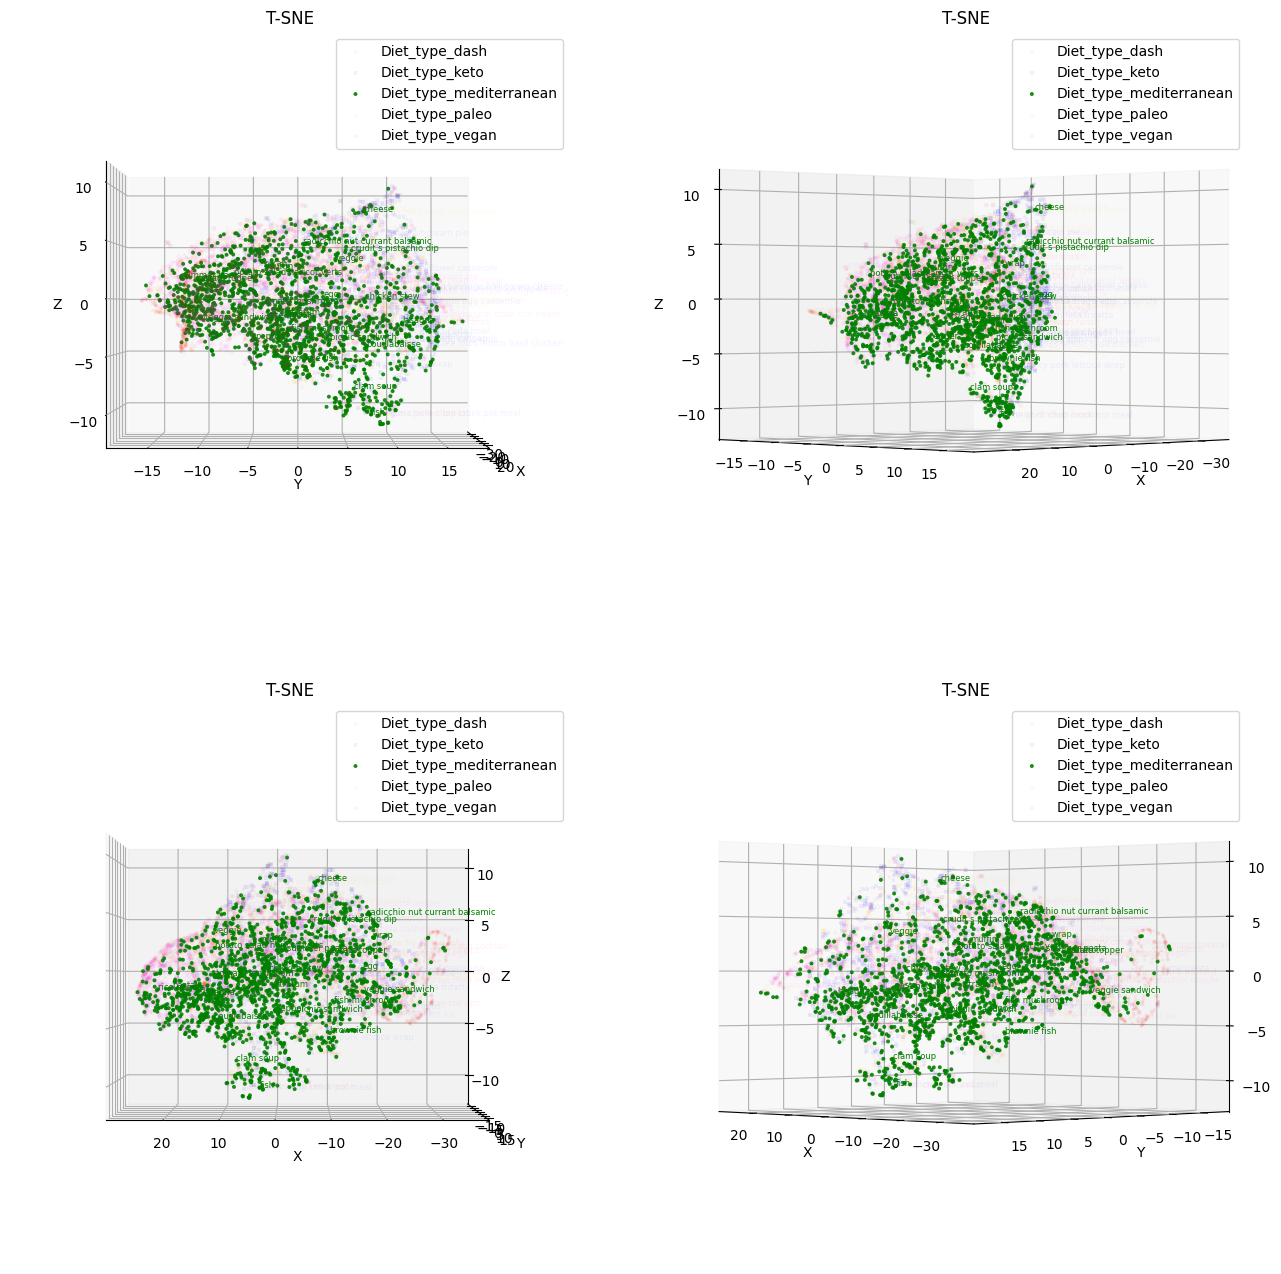

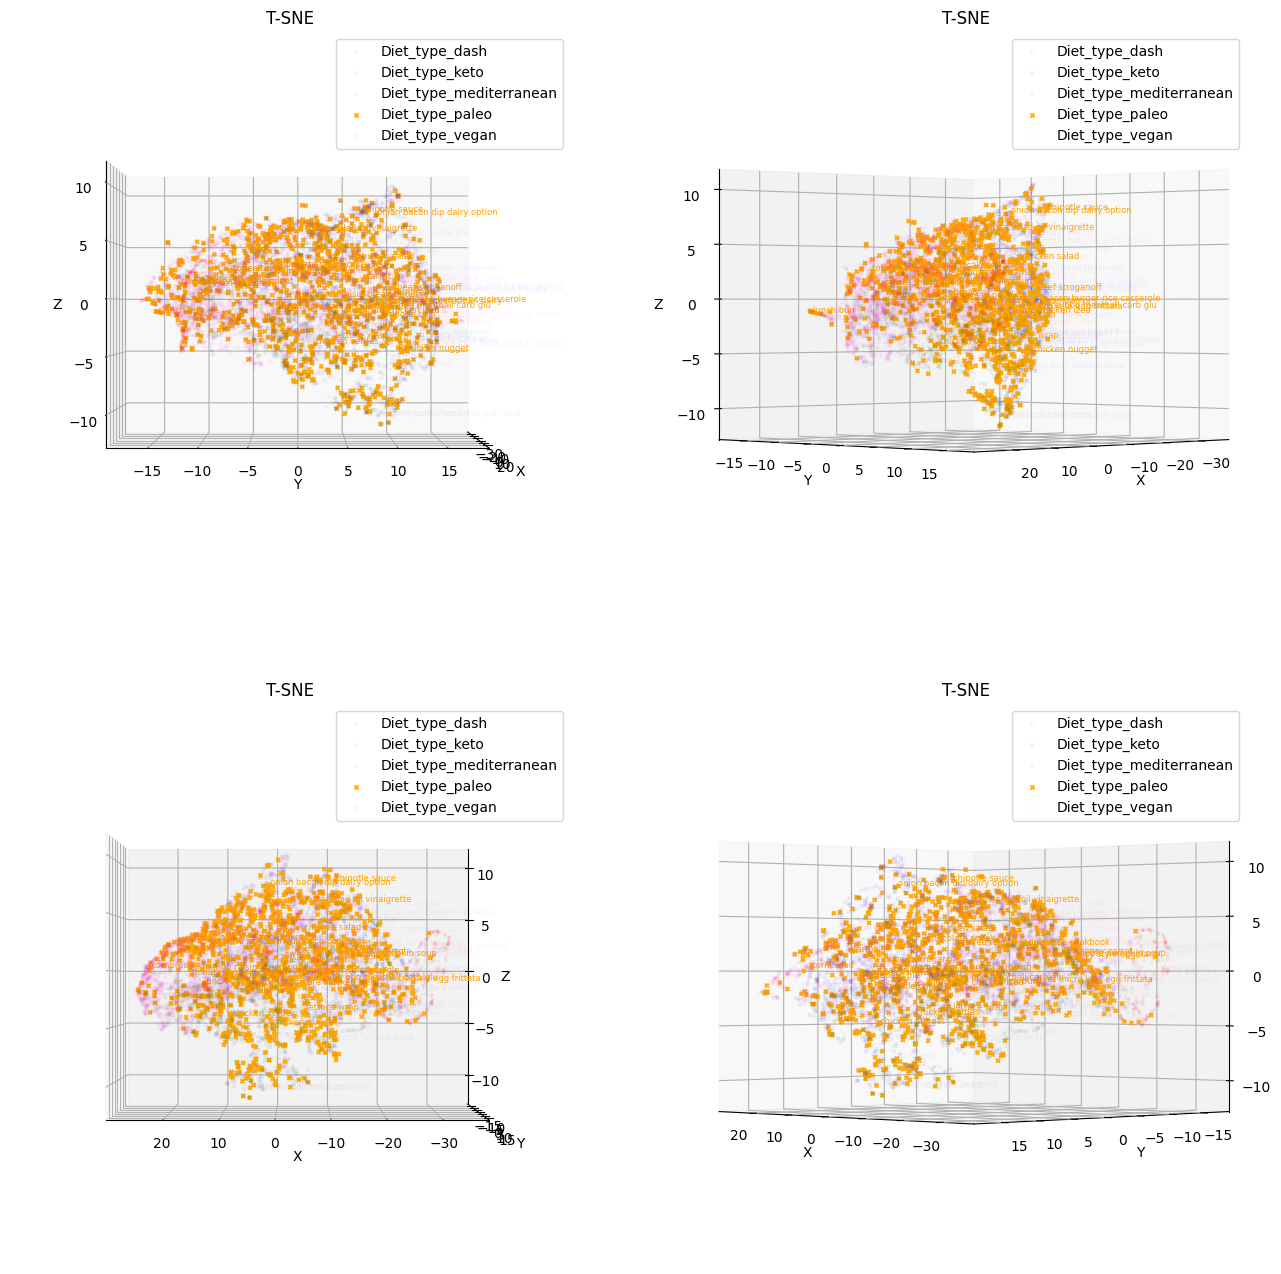

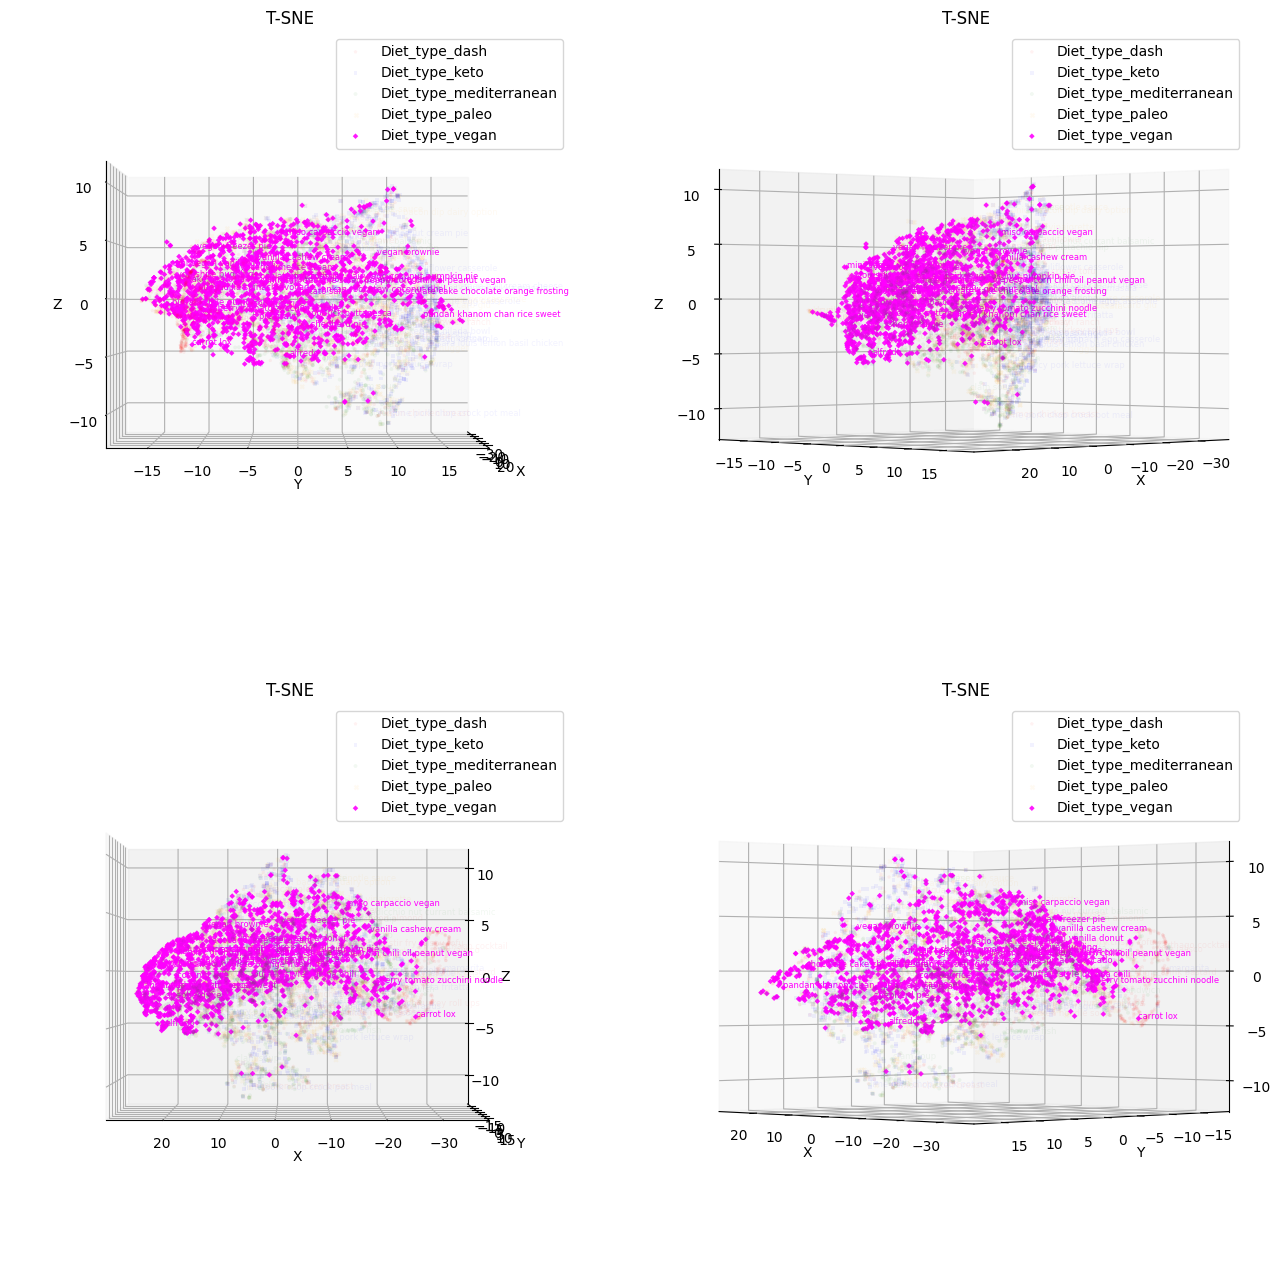

In [ ]:

for diet_type in range(len(colors)):
    fig = plt.figure(diet_type,figsize=(16, 16))
    for plot in range(4):
        ax = fig.add_subplot(221+plot, projection='3d')

        # Iterar sobre cada clase y graficar puntos con su color correspondiente
        for i in range(len(colors)):
            class_indices = np.where(color_indices == i)[0]
            ax.scatter(X_embedded[class_indices, 0], X_embedded[class_indices, 1], X_embedded[class_indices, 2],
                    c=colors[i], label=column_names[i], marker=markers[i], edgecolor='none', s=8,alpha = 0.9 if i ==diet_type else 0.05)

        # Seleccionar 50 elementos por clase para etiquetar
        for i in range(len(colors)):
            for idx in selected_indices[i]:
                ax.text(X_embedded[idx, 0], X_embedded[idx, 1], X_embedded[idx, 2], ' '.join(all_nouns[idx]), size=6, zorder=1, color=colors[i],alpha = 1 if i ==diet_type else 0.05)

        ax.set_title('T-SNE')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.view_init(elev=0, azim=angles[plot])

        ax.legend()
    plt.show()

In [25]:
X_train,X_test,y_train,y_test = train_test_split(X_embedded,color_indices,random_state=1)
kmeans = KMeans(n_clusters=600)
kmeans.fit(X_train,y_train)
y_pred = kmeans.predict(X_test)

NameError: name 'X_embedded' is not defined

index  0
pumpkin pie
peach crisp
dirty cauliflower rice
swiss s bug bunny hasenpfeffer stew
homemade ravioli with ricotta cheese and spinach filling
pecan pie
vietnamese spring roll
flour crust for tart or pie gluten free low carb sugar free
blueberry french toast casserole
instant pot chicken marinara
caramel frappuccino
peppermint macaroon
sesame orange vinaigrette
meatball
crockpot drumstick
zucchini hummus
chicken nugget
lunch idea
bbq chicken
cashew cream cheese
coconut shrimp
berry crumble bar
vegan chicken nugget
vegan meatball
vegan brownie
vegan pumpkin pull loaf
vegan eggplant parmesan
vegan coconut curry noodle bowl
vegan gravy
vegan spring risotto
low key iridofu or scrambled tofu with vegetable
vegan sesame grill
vegan chocolate babka
vegan kale pesto pasta
vegan chocolate frosting
root vegetable jazzed up
vegan lemon fettuccine alfredo
molten lava cake in microwave
honey cake
indian cauliflower with black mustard seed
vegan coconut banana ice cream
vegan lentil bolognese 

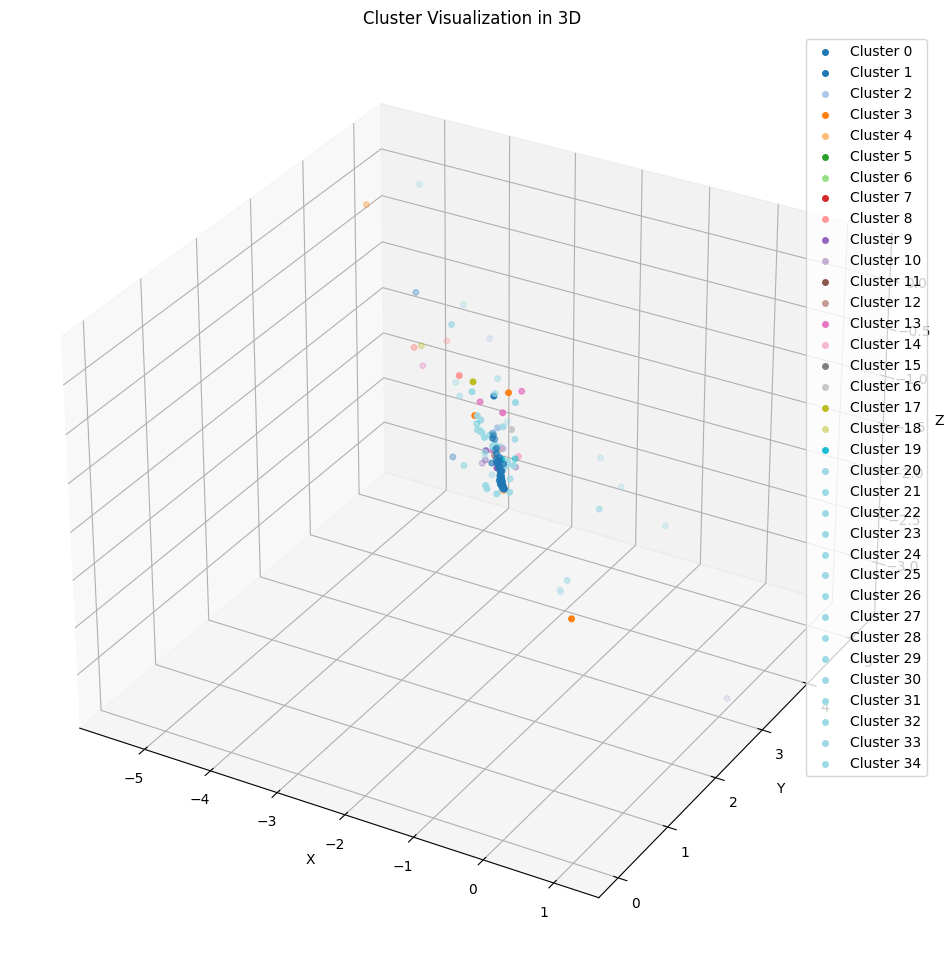

In [24]:
# Crear una figura 3D
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# Colores para los clusters
colors = plt.cm.get_cmap('tab20', 22)

# Graficar los puntos de prueba con colores según sus clusters
for i in range(35):
    class_indices = np.where(y_pred == i)[0]
    cluster_points = X_test[y_pred == i]
    print("index ",i)
    for idx in class_indices:
        print(recipes[idx])
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], 
               color=colors(i), label=f'Cluster {i}', s=45)

# Etiquetas y título
ax.set_title('Cluster Visualization in 3D')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

# Mostrar la gráfica
plt.show()
